In [1]:
building_id = 3
price = 400
iteration = 0
import sys
sys.path.append("..")

In [2]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = '../energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = '../ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = '../energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = '../ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [3]:
########### OUTPUT FILES ###############

# EnergyPlus
try:
    output_dir = EP_output_dir
    error_dir  = EP_output_dir
except:
    output_dir = '../energy_plus/output_energy_plus'
    error_dir  = '../energy_plus/output_energy_plus'
# EHUB
res_file   = '../ehub/output_ehub_excel/' + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "../rendered_pv_factors/bc/"

# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [6]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## the North Axis
The north axis gets grabbed automatically from the idf.

In [7]:
pvbuilding.North_Axis

0.0

In [8]:
pvbuilding.Building_Information


Building,
    Ref Bldg Warehouse New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    40,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [9]:
# Determine the hourly electricity use
pvbuilding.run_ep()

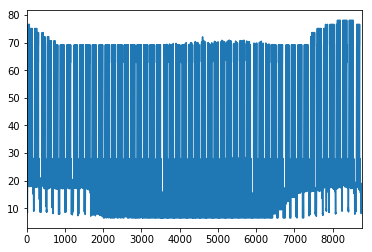

In [10]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [11]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 10,626.92
78.13965517957509


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [12]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 4,598 m2
Roof area is up 70 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [13]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

In [14]:
import numpy as np
all_220_irr = []
for i, gcr in enumerate(np.arange(0.2,0.9,0.05)):
    print(gcr)
    all_220_irr.append(pvpanel.irradiance(220,35,gcr,force_recalc=False))
all_180_irr = []
for i, gcr in enumerate(np.arange(0.2,0.9,0.05)):
    print(gcr)
    all_180_irr.append(pvpanel.irradiance(180,35,gcr,force_recalc=False))
all_140_irr = []
for i, gcr in enumerate(np.arange(0.2,0.9,0.05)):
    print(gcr)
    all_140_irr.append(pvpanel.irradiance(140,35,gcr,force_recalc=False))
all_0_irr = []
for i, gcr in enumerate(np.arange(0.2,0.9,0.05)):
    print(gcr)
    all_0_irr.append(pvpanel.irradiance(180,1,gcr,force_recalc=False))

0.2


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.69933533668518 sec
ERROR:root:Finished Generation of Irradiance


0.25


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.930407524108887 sec
ERROR:root:Finished Generation of Irradiance


0.3


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.563114881515503 sec
ERROR:root:Finished Generation of Irradiance


0.35


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.016536712646484 sec
ERROR:root:Finished Generation of Irradiance


0.39999999999999997


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 11.036177396774292 sec
ERROR:root:Finished Generation of Irradiance


0.44999999999999996


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.649932146072388 sec
ERROR:root:Finished Generation of Irradiance


0.49999999999999994


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.556581735610962 sec
ERROR:root:Finished Generation of Irradiance


0.5499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.783828973770142 sec
ERROR:root:Finished Generation of Irradiance


0.5999999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.596770286560059 sec
ERROR:root:Finished Generation of Irradiance


0.6499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.531982898712158 sec
ERROR:root:Finished Generation of Irradiance


0.7


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.764830350875854 sec
ERROR:root:Finished Generation of Irradiance


0.7499999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.750743865966797 sec
ERROR:root:Finished Generation of Irradiance


0.7999999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.649410247802734 sec
ERROR:root:Finished Generation of Irradiance


0.8499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.689607620239258 sec
ERROR:root:Finished Generation of Irradiance


0.2


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.66317081451416 sec
ERROR:root:Finished Generation of Irradiance


0.25


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.516082763671875 sec
ERROR:root:Finished Generation of Irradiance


0.3


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.53169322013855 sec
ERROR:root:Finished Generation of Irradiance


0.35


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.605874300003052 sec
ERROR:root:Finished Generation of Irradiance


0.39999999999999997


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.704983234405518 sec
ERROR:root:Finished Generation of Irradiance


0.44999999999999996


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.58145260810852 sec
ERROR:root:Finished Generation of Irradiance


0.49999999999999994


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.55733323097229 sec
ERROR:root:Finished Generation of Irradiance


0.5499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.566652774810791 sec
ERROR:root:Finished Generation of Irradiance


0.5999999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 10.862473964691162 sec
ERROR:root:Finished Generation of Irradiance


0.6499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.545886278152466 sec
ERROR:root:Finished Generation of Irradiance


0.7


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.82576608657837 sec
ERROR:root:Finished Generation of Irradiance


0.7499999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.554322004318237 sec
ERROR:root:Finished Generation of Irradiance


0.7999999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.604079246520996 sec
ERROR:root:Finished Generation of Irradiance


0.8499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.501028060913086 sec
ERROR:root:Finished Generation of Irradiance


0.2


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.755833148956299 sec
ERROR:root:Finished Generation of Irradiance


0.25


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.617967128753662 sec
ERROR:root:Finished Generation of Irradiance


0.3


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.562427520751953 sec
ERROR:root:Finished Generation of Irradiance


0.35


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.63772463798523 sec
ERROR:root:Finished Generation of Irradiance


0.39999999999999997


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.210315704345703 sec
ERROR:root:Finished Generation of Irradiance


0.44999999999999996


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.461462497711182 sec
ERROR:root:Finished Generation of Irradiance


0.49999999999999994


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.452934503555298 sec
ERROR:root:Finished Generation of Irradiance


0.5499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.3738112449646 sec
ERROR:root:Finished Generation of Irradiance


0.5999999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.540459871292114 sec
ERROR:root:Finished Generation of Irradiance


0.6499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.5901038646698 sec
ERROR:root:Finished Generation of Irradiance


0.7


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.72027063369751 sec
ERROR:root:Finished Generation of Irradiance


0.7499999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.549632787704468 sec
ERROR:root:Finished Generation of Irradiance


0.7999999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.304637670516968 sec
ERROR:root:Finished Generation of Irradiance


0.8499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.586321830749512 sec
ERROR:root:Finished Generation of Irradiance


0.2


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.03318452835083 sec
ERROR:root:Finished Generation of Irradiance


0.25


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.669523477554321 sec
ERROR:root:Finished Generation of Irradiance


0.3


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.129976272583008 sec
ERROR:root:Finished Generation of Irradiance


0.35


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.154303550720215 sec
ERROR:root:Finished Generation of Irradiance


0.39999999999999997


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.519343137741089 sec
ERROR:root:Finished Generation of Irradiance


0.44999999999999996


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.177565097808838 sec
ERROR:root:Finished Generation of Irradiance


0.49999999999999994


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.158490419387817 sec
ERROR:root:Finished Generation of Irradiance


0.5499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.728516578674316 sec
ERROR:root:Finished Generation of Irradiance


0.5999999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 10.627111434936523 sec
ERROR:root:Finished Generation of Irradiance


0.6499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.942831754684448 sec
ERROR:root:Finished Generation of Irradiance


0.7


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.171136379241943 sec
ERROR:root:Finished Generation of Irradiance


0.7499999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 9.880787372589111 sec
ERROR:root:Finished Generation of Irradiance


0.7999999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.140142917633057 sec
ERROR:root:Finished Generation of Irradiance


0.8499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.060274124145508 sec
ERROR:root:Finished Generation of Irradiance


In [18]:
all_0_irr = []
for i, gcr in enumerate(np.arange(0.2,0.9,0.05)):
    print(gcr)
    all_0_irr.append(pvpanel.irradiance(180,1,gcr,force_recalc=False))

0.2


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.495141744613647 sec
ERROR:root:Finished Generation of Irradiance


0.25


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.500483751296997 sec
ERROR:root:Finished Generation of Irradiance


0.3


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.58083200454712 sec
ERROR:root:Finished Generation of Irradiance


0.35


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.493863344192505 sec
ERROR:root:Finished Generation of Irradiance


0.39999999999999997


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.672439098358154 sec
ERROR:root:Finished Generation of Irradiance


0.44999999999999996


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.637938976287842 sec
ERROR:root:Finished Generation of Irradiance


0.49999999999999994


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.756065130233765 sec
ERROR:root:Finished Generation of Irradiance


0.5499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 10.144338607788086 sec
ERROR:root:Finished Generation of Irradiance


0.5999999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.765509605407715 sec
ERROR:root:Finished Generation of Irradiance


0.6499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.665328979492188 sec
ERROR:root:Finished Generation of Irradiance


0.7


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 10.549713850021362 sec
ERROR:root:Finished Generation of Irradiance


0.7499999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.896559953689575 sec
ERROR:root:Finished Generation of Irradiance


0.7999999999999998


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 10.859241247177124 sec
ERROR:root:Finished Generation of Irradiance


0.8499999999999999


ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.484418392181396 sec
ERROR:root:Finished Generation of Irradiance


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


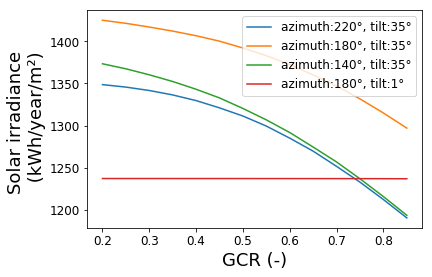

In [20]:
total_220_irr = []
for i in all_220_irr:
    total_220_irr.append(sum(i/1000))

total_180_irr = []
for i in all_180_irr:
    total_180_irr.append(sum(i/1000))    
    
total_140_irr = []
for i in all_140_irr:
    total_140_irr.append(sum(i/1000))  
    

total_0_irr = []
for i in all_0_irr:
    total_0_irr.append(sum(i/1000))  

import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

plt.plot(np.arange(0.2,0.9,0.05),(total_220_irr),label="azimuth:220°, tilt:35°")
plt.plot(np.arange(0.2,0.9,0.05),(total_180_irr),label="azimuth:180°, tilt:35°")
plt.plot(np.arange(0.2,0.9,0.05),(total_140_irr),label="azimuth:140°, tilt:35°")
plt.plot(np.arange(0.2,0.9,0.05),(total_0_irr),label="azimuth:180°, tilt:1°")

plt.ylabel("Solar irradiance \n (kWh/year/m²)", fontsize=18)
plt.xlabel("GCR (-)", fontsize=18)
plt.legend()
plt.savefig('../paper_images/solar_irradiance.png', bbox_inches='tight')

In [21]:
import numpy as np
all_irr = []
for i, gcr in enumerate(np.arange(0.2,0.9,0.05)):
     all_irr.append(pvpanel.irradiance_non(180,35,gcr,force_recalc=True))

[1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464, 1392003.0318976464]


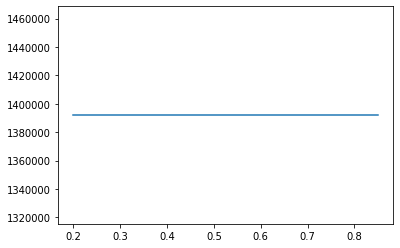

In [22]:
total_irr = []
for i in all_irr:
    total_irr.append(sum(i))
    
import matplotlib.pyplot as plt
plt.plot(np.arange(0.2,0.9,0.05),total_irr)
print(total_irr)

In [ ]:
faster_render = [1424941.969393252, 1421272.2006476382, 1416903.177541356, 1412063.583568177, 1406555.6899765856, 1400120.7990447613, 1392003.031897647, 1382926.2007368202, 1372411.133043467, 1360044.963430121, 1346932.5707026552, 1331640.5600599195, 1314960.2721188117, 1296996.3867861629]
slower_render = [1424941.969183414, 1421272.2001565727, 1416903.1764957206, 1412063.5814907167, 1406555.6860880023, 1400120.7920897796, 1392003.0200071614, 1382926.181183335, 1372411.1019082612, 1360044.9155107955, 1346932.4989307222, 1331640.456149183, 1314960.1255035445, 1296996.1855772743]

faster_render-slower_render

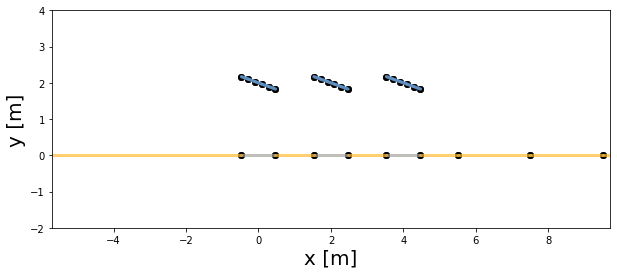

1


In [75]:
# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
#import warnings
#warnings.filterwarnings("ignore", category=RuntimeWarning)

# Settings
%matplotlib inline
np.set_printoptions(precision=3)
from pvfactors.geometry import OrderedPVArray

pp = {
    'n_pvrows': 3,               # number of pv rows
    'pvrow_height': 2,           # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,            # width of pvrows [m]
    'pvrow_depth': 1,            # depth of the panel [m]
    'axis_azimuth': 0,           # azimuth angle of rotation axis
    'surface_tilt': 20.,         # tilt of the pv rows
    'surface_azimuth': 90.,      # azimuth of the pv rows front surface
    'solar_zenith': 60.,         # solar zenith angle
    'solar_azimuth': 180.,       # solar azimuth angle
    'gcr': 0.5,                  # ground coverage ratio
    'albedo': 0.2,               # ground surface reflectivity (used to be rho_ground)
    'rho_front_pvrow': 0.01,     # front surface reflectivity of PV rows
    'rho_back_pvrow': 0.01       # back surface reflectivity of PV rows
}
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'surface_tilt': 20.,      # tilt of the pv rows
    'surface_azimuth': 270.,   # azimuth of the pv rows front surface
    'solar_zenith': 40.,      # solar zenith angle
    'solar_azimuth': 150.,    # solar azimuth angle
    'gcr': 0.5,               # ground coverage ratio
}
discretization = {'cut':{
    0: {'front': 5},  # discretize the back side of the leftmost PV row into 5 segments
    1: {'front': 5},  # discretize the front side of the center PV row into 3 segments
    2: {'front': 5}
}}
pp.update(discretization)
from pvfactors.geometry import OrderedPVArray
# Create pv array
pvarray = OrderedPVArray.fit_from_dict_of_scalars(pp,param_names=["1","3","5"])

# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 4))
pvarray.plot_at_idx(0, ax)
plt.show()

print(pvarray.param_names.index("3"))